In [548]:
from sklearn.model_selection import RepeatedKFold

In [549]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [550]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.base import clone

In [551]:
RANDOM_STATE=42

# Loading Datasets

y_train and y_test is the same for all datasets

In [552]:
y_test = np.load("y_test_bow.npy")
y_train = np.load("y_train_bow.npy")

In [553]:
print(y_test.shape)

(45,)


Transcript BOW

In [554]:
X_train_bow = np.load("X_train_bow.npy")
X_test_bow = np.load("X_test_bow.npy")

Mean word2vec

In [555]:
X_train_w = np.load("X_train_mean_w2v.npy")
X_test_w = np.load("X_test_mean_w2v.npy")

Doc2vec

In [556]:
X_train_d = np.load("X_train_doc2vec.npy")
X_test_d = np.load("X_test_doc2vec.npy")

Tfidf

In [557]:
X_train_tf = np.load("X_train_tfidf.npy")
X_test_tf = np.load("X_test_tfidf.npy")

Pronouns

In [558]:
X_train_p = np.load("X_train_pronoun.npy", allow_pickle = True)
X_test_p = np.load("X_test_pronoun.npy", allow_pickle = True)

Gaze features

In [568]:
# f0
X_train_g0 = np.load("X_train_g0.npy")
X_test_g0 = np.load("X_test_g0.npy")

# f1
X_train_g1 = np.load("X_train_g1.npy")
X_test_g1 = np.load("X_test_g1.npy")

# fh0
X_train_gh0 = np.load("X_train_gh0.npy")
X_test_gh0 = np.load("X_test_gh0.npy")

# fh1
X_train_gh1 = np.load("X_train_gh1.npy")
X_test_gh1 = np.load("X_test_gh1.npy")

# f01
X_train_g01 = np.load("X_train_g01.npy")
X_test_g01 = np.load("X_test_g01.npy")

# fh0h1
X_train_gh0h1 = np.load("X_train_gh0h1.npy")
X_test_gh0h1 = np.load("X_test_gh0h1.npy")

# Evaluation

In [569]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

# Custom Ensemble

In [570]:
class Ensemble:
    def __init__(self):
        self.clf = []
        self.X_train = []
        self.X_test = []
        self.y_train = None
        self.y_test = None
        
    def set_clf(self, ls_clf):
        self.clf = ls_clf
    
    def set_train_test(self, ls_train, ls_test, y_train, y_test):
        self.X_train = ls_train
        self.X_test = ls_test
        self.y_train = y_train
        self.y_test = y_test
        
    def train_ens(self):
        for i in range(len(self.clf)):
            c_i = self.clf[i]
            X_train_i = self.X_train[i]
            y_train_i = self.y_train
            c_i.fit(X_train_i, y_train_i)
            self.clf[i] = c_i
    
    def pred_proba(self, ls_X):
        probas = []
        for i in range(len(self.clf)):
            c_i = self.clf[i]
            probas.append(c_i.predict_proba(ls_X[i]))
        probas = np.array(probas)
        probas = np.mean(probas, axis=0)
        return probas
    
    def pred_ens(self, ls_X):

        probas = self.pred_proba(ls_X)
        label = np.argmax(probas)
        return label
    
    def evaluate_ens(self):
        predictions = []       
        for i in range(len(self.y_test)):
            ls_X = []
            for j in range(len(self.clf)):
                ls_X.append(self.X_test[j][i:i+1][:])
            predictions.append(self.pred_ens(ls_X))
        predictions = np.array(predictions)
        print(predictions)
        print(self.y_test)
        
        evaluate_on_training_set(self.y_test, predictions)
        
    def ens_kcross(self, k=3, n=4, random_state=RANDOM_STATE):
        f1_scores = []
        recall_scores = []
        rkf = RepeatedKFold(n_splits=k, n_repeats=n, random_state=random_state)
        X = self.X_train[0]
        X_val_ls = []
                
        for train_index, val_index in rkf.split(X):
            
            for i in range(len(self.clf)):
                model = self.clf[i]
                X = self.X_train[i]
                y = self.y_train
                
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                model.fit(X_train, y_train) 
                
                X_val_ls.append(X_val)
            
                
            predictions = []       
            for i in range(len(y_val)):
                ls_X = []
                for j in range(len(self.clf)):
                    ls_X.append(np.array([X_val_ls[j][i]]))
                pred = self.pred_ens(ls_X)
                predictions.append(pred)
            predictions = np.array(predictions)
            
            f1 = f1_score(y_val, predictions)
            f1_scores.append(f1)
            recall = recall_score(y_val, predictions)
            recall_scores.append(recall)

        return f1_scores, recall_scores
    
        

In [642]:
# Set the models with best parameters
clf_b1 = LogisticRegression(C=1000000)
clf_b2 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, min_samples_leaf=13)
clf_b3 = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=23) 
clf_w1 = LogisticRegression(C=100)
clf_w2 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1)
clf_w3 = SVC(C= 10, kernel ='linear', probability=True)
clf_tf = SVC(C= 10, kernel ='linear', probability=True)
clf_p = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=1, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=23, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
clf_g0 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=2, min_samples_leaf=15) 
clf_g1 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3, min_samples_leaf=12) 
clf_gh1 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=3, min_samples_leaf=14)

# clfs = [clf_b1, clf_b2, clf_b3, clf_w1, clf_w2, clf_w3, clf_tf, clf_p, clf_g1, clf_gh1]
clfs = [clf_b2, clf_w2, clf_tf, clf_gh1]


# X_train_ls = [X_train_bow, X_train_bow, X_train_bow, X_train_w, X_train_w, X_train_w, X_train_tf, X_train_p, X_train_g1, X_train_gh1]
# X_test_ls = [X_test_bow, X_test_bow, X_test_bow, X_test_w, X_test_w, X_test_w, X_test_tf, X_test_p, X_test_g1, X_test_gh1]

X_train_ls = [X_train_bow, X_train_w, X_train_tf, X_train_gh1]
X_test_ls = [X_test_bow, X_test_w, X_test_tf, X_test_gh1]

In [643]:
e = Ensemble()
e.set_clf(clfs)
e.set_train_test(X_train_ls, X_test_ls, y_train, y_test)

In [644]:
f1_scores, recall_scores = e.ens_kcross()
print("F1 score: {}, Recall score: {}".format(np.mean(f1_scores), np.mean(recall_scores)))

F1 score: 0.512526255425489, Recall score: 0.5824474341018459


In [645]:
e.train_ens()

[0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1
 0 1 0 1 1 1 1 1]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0]
AUC is:  0.5149769585253456
              precision    recall  f1-score   support

           0       0.71      0.39      0.50        31
           1       0.32      0.64      0.43        14

    accuracy                           0.47        45
   macro avg       0.51      0.51      0.46        45
weighted avg       0.59      0.47      0.48        45

Confusion Matrix: 
 [[12 19]
 [ 5  9]]


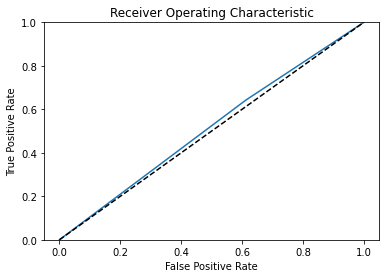

In [646]:
e.evaluate_ens()